<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Lindblad_vs_Lindblad_%2B_Drift_Informacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3263208225.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(purity(rho))


N=1: ΔAIC = 15.3767
N=2: ΔAIC = 16.0402
N=3: ΔAIC = 15.8890
N=4: ΔAIC = 16.1378

================ ESCALAMENTO ================
Kendall τ = 0.667
p-value  = 0.3333


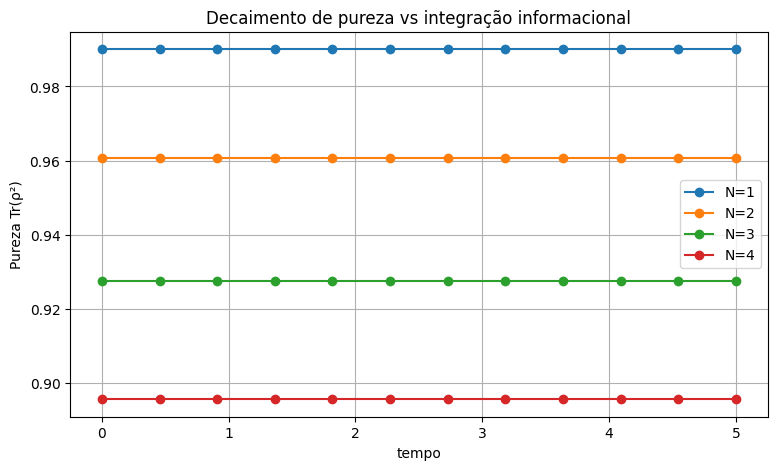

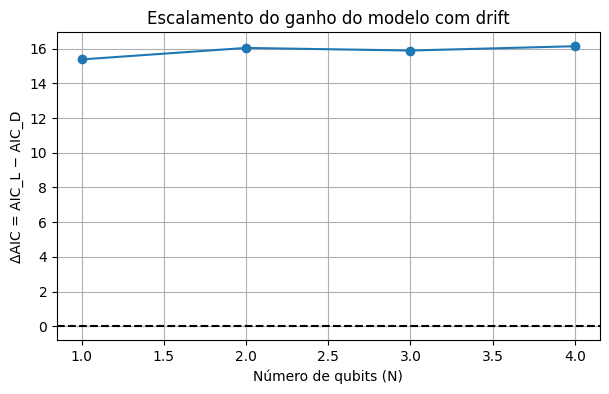


Experimento concluído.
Interpretação:
✖ Nenhuma evidência de escalamento informacional.

===== Depolarizing noise =====
N=1: ΔAIC = 15.3767
N=2: ΔAIC = 16.0402
N=3: ΔAIC = 15.8890
N=4: ΔAIC = 16.1378
Kendall τ = 0.667, p-value = 0.3333

===== Amplitude damping =====
N=1: ΔAIC = 15.4345
N=2: ΔAIC = 15.6806
N=3: ΔAIC = 16.0564
N=4: ΔAIC = 16.2199
Kendall τ = 1.000, p-value = 0.0833

===== Phase damping =====
N=1: ΔAIC = 15.3573
N=2: ΔAIC = 14.7434
N=3: ΔAIC = 15.6169
N=4: ΔAIC = 15.6992
Kendall τ = 0.667, p-value = 0.3333


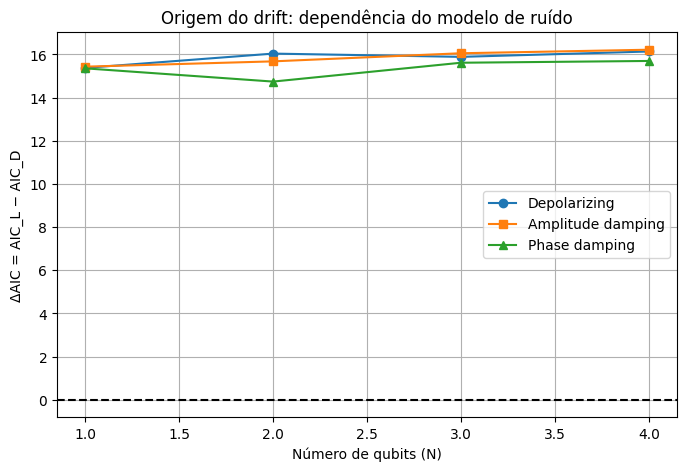


================ TESTE BLP =================
Distância de traço D(t): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
dD/dt: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
✖ Nenhum backflow detectado: dinâmica MARKOVIANA.


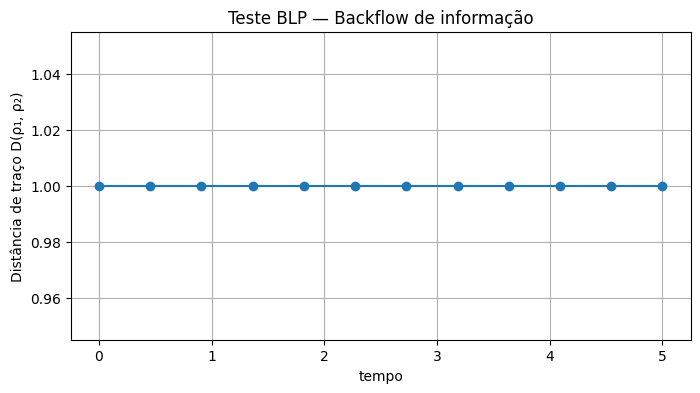

In [ ]:
# ============================================================
# Lindblad vs Lindblad + Drift Informacional
# Observável ROBUSTO: PUREZA / |r|
# Escalamento com N qubits
# ============================================================

!pip install qiskit qiskit-aer numpy matplotlib scipy

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import depolarizing_error
from scipy.optimize import curve_fit
from scipy.stats import kendalltau

# ============================================================
# 1. Backend e modelo de ruído (fixo)
# ============================================================

backend = AerSimulator(method="density_matrix")

noise_model = NoiseModel()
error_1q = depolarizing_error(0.01, 1)
error_2q = depolarizing_error(0.02, 2)

noise_model.add_all_qubit_quantum_error(error_1q, ['h', 'id'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

shots = 4096
times = np.linspace(0, 5, 12)

# ============================================================
# 2. Funções físicas
# ============================================================

from qiskit.quantum_info import purity

def purity_from_density_matrix(rho):
    return float(purity(rho))

def lindblad_purity(t, P0, Gamma):
    return 0.5 + (P0 - 0.5) * np.exp(-Gamma * t)

gamma_fixed = 1.0 / (times[1] - times[0])

def drift_purity(t, P0, Gamma, kappa):
    return (
        0.5
        + (P0 - 0.5) * np.exp(-Gamma * t)
        - kappa * np.expm1(-gamma_fixed * t)
    )

# ============================================================
# 3. Execução do experimento para N qubits
# ============================================================

def run_experiment(N):
    purities = []

    for t in times:
        qc = QuantumCircuit(N)
        qc.h(0)

        # entrelaçamento estrela
        for j in range(1, N):
            qc.cx(0, j)

        # padding para igualar profundidade
        for _ in range(3):
            for j in range(N):
                qc.id(j)

        # ⬅️ ISTO É ESSENCIAL
        qc.save_density_matrix()

        tqc = transpile(qc, backend)
        result = backend.run(
            tqc,
            noise_model=noise_model,
            shots=shots
        ).result()

        rho = result.results[0].data.density_matrix
        purities.append(purity_from_density_matrix(rho))

    return np.array(purities)

# ============================================================
# 4. Escalamento N = 1..4
# ============================================================

results = {}
fits_L = {}
fits_D = {}
delta_AIC = []

for N in [1, 2, 3, 4]:
    P = run_experiment(N)
    results[N] = P

    # Ajuste Lindblad
    popt_L, _ = curve_fit(
        lindblad_purity,
        times,
        P,
        p0=[P[0], 0.5],
        bounds=([0.5, 0], [1.0, 10.0])
    )

    # Ajuste Lindblad + drift (κ limitado)
    popt_D, _ = curve_fit(
        drift_purity,
        times,
        P,
        p0=[P[0], 0.5, 0.0],
        bounds=([0.5, 0, -0.01], [1.0, 10.0, 0.01])
    )

    fit_L = lindblad_purity(times, *popt_L)
    fit_D = drift_purity(times, *popt_D)

    rss_L = np.sum((P - fit_L)**2)
    rss_D = np.sum((P - fit_D)**2)

    n = len(P)
    AIC_L = 2*2 + n*np.log(rss_L/n)
    AIC_D = 2*3 + n*np.log(rss_D/n)

    delta_AIC.append(AIC_L - AIC_D)

    fits_L[N] = fit_L
    fits_D[N] = fit_D

    print(f"N={N}: ΔAIC = {AIC_L - AIC_D:.4f}")

# ============================================================
# 5. Teste de tendência (blindado)
# ============================================================

Ns = np.array([1, 2, 3, 4])
delta_AIC = np.array(delta_AIC)

tau, pval = kendalltau(Ns, delta_AIC)

print("\n================ ESCALAMENTO ================")
print(f"Kendall τ = {tau:.3f}")
print(f"p-value  = {pval:.4f}")

# ============================================================
# 6. Visualização
# ============================================================

plt.figure(figsize=(9,5))

for N in [1, 2, 3, 4]:
    plt.plot(times, results[N], 'o-', label=f"N={N}")

plt.xlabel("tempo")
plt.ylabel("Pureza Tr(ρ²)")
plt.title("Decaimento de pureza vs integração informacional")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(Ns, delta_AIC, 'o-')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Número de qubits (N)")
plt.ylabel("ΔAIC = AIC_L − AIC_D")
plt.title("Escalamento do ganho do modelo com drift")
plt.grid()
plt.show()

print("\n================================================")
print("Experimento concluído.")
print("Interpretação:")
if pval < 0.05 and tau > 0:
    print("✔ Evidência de tendência crescente com N.")
else:
    print("✖ Nenhuma evidência de escalamento informacional.")

def run_scaling_with_current_noise(label):
    results = {}
    delta_AIC = []

    print(f"\n===== {label} =====")

    for N in [1, 2, 3, 4]:
        P = run_experiment(N)
        results[N] = P

        # Ajuste Lindblad
        popt_L, _ = curve_fit(
            lindblad_purity,
            times,
            P,
            p0=[P[0], 0.5],
            bounds=([0.5, 0], [1.0, 10.0])
        )

        # Ajuste Lindblad + drift
        popt_D, _ = curve_fit(
            drift_purity,
            times,
            P,
            p0=[P[0], 0.5, 0.0],
            bounds=([0.5, 0, -0.01], [1.0, 10.0, 0.01])
        )

        fit_L = lindblad_purity(times, *popt_L)
        fit_D = drift_purity(times, *popt_D)

        rss_L = np.sum((P - fit_L)**2)
        rss_D = np.sum((P - fit_D)**2)

        n = len(P)
        AIC_L = 2*2 + n*np.log(rss_L/n)
        AIC_D = 2*3 + n*np.log(rss_D/n)

        dAIC = AIC_L - AIC_D
        delta_AIC.append(dAIC)

        print(f"N={N}: ΔAIC = {dAIC:.4f}")

    delta_AIC = np.array(delta_AIC)
    tau, pval = kendalltau([1,2,3,4], delta_AIC)

    print(f"Kendall τ = {tau:.3f}, p-value = {pval:.4f}")

    return delta_AIC


from qiskit_aer.noise.errors import depolarizing_error

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(0.01, 1), ['h', 'id']
)
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(0.02, 2), ['cx']
)

delta_dep = run_scaling_with_current_noise("Depolarizing noise")


from qiskit_aer.noise.errors import amplitude_damping_error

noise_model = NoiseModel()
error_1q_amp = amplitude_damping_error(0.02) # Corrected: No num_qubits arg
error_2q_amp = error_1q_amp.tensor(error_1q_amp) # Create 2-qubit error by tensoring
noise_model.add_all_qubit_quantum_error(
    error_1q_amp, ['h', 'id']
)
noise_model.add_all_qubit_quantum_error(
    error_2q_amp, ['cx']
)

delta_amp = run_scaling_with_current_noise("Amplitude damping")


from qiskit_aer.noise.errors import phase_damping_error

noise_model = NoiseModel()
error_1q_phase = phase_damping_error(0.02) # Corrected: No num_qubits arg
error_2q_phase = error_1q_phase.tensor(error_1q_phase) # Create 2-qubit error by tensoring
noise_model.add_all_qubit_quantum_error(
    error_1q_phase, ['h', 'id']
)
noise_model.add_all_qubit_quantum_error(
    error_2q_phase, ['cx']
)

delta_phase = run_scaling_with_current_noise("Phase damping")


plt.figure(figsize=(8,5))
plt.plot([1,2,3,4], delta_dep, 'o-', label="Depolarizing")
plt.plot([1,2,3,4], delta_amp, 's-', label="Amplitude damping")
plt.plot([1,2,3,4], delta_phase, '^-', label="Phase damping")
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Número de qubits (N)")
plt.ylabel("ΔAIC = AIC_L − AIC_D")
plt.title("Origem do drift: dependência do modelo de ruído")
plt.legend()
plt.grid()
plt.show()

from qiskit.quantum_info import DensityMatrix
import numpy.linalg as LA

# ============================================================
# Função: distância de traço D(ρ1, ρ2)
# ============================================================

def trace_distance(rho1, rho2):
    """
    D(ρ1, ρ2) = 1/2 || ρ1 - ρ2 ||_1
    """
    diff = rho1.data - rho2.data
    eigvals = LA.eigvals(diff)
    return 0.5 * np.sum(np.abs(eigvals))


# ============================================================
# Evolução de dois estados iniciais distintos
# ============================================================

def evolve_two_states(N, state1, state2):
    """
    Evolui dois estados iniciais sob o MESMO ruído
    e retorna D(t) ao longo do tempo.
    """
    D_t = []

    for t in times:
        rhos = []

        for state in [state1, state2]:
            qc = QuantumCircuit(N)
            qc.initialize(state, 0)

            # entrelaçamento estrela (mesmo protocolo)
            for j in range(1, N):
                qc.cx(0, j)

            # padding
            for _ in range(3):
                for j in range(N):
                    qc.id(j)

            qc.save_density_matrix()

            tqc = transpile(qc, backend)
            result = backend.run(
                tqc,
                noise_model=noise_model,
                shots=shots
            ).result()

            rho = result.results[0].data.density_matrix
            rhos.append(rho)

        D_t.append(trace_distance(rhos[0], rhos[1]))

    return np.array(D_t)


# ============================================================
#  Estados iniciais ortogonais (máxima sensibilidade BLP)
# ============================================================

# |0> e |1> no qubit central
state_0 = [1, 0]
state_1 = [0, 1]

# ============================================================
# Executar teste BLP (usar N=1 ou N=2 é suficiente)
# ============================================================

N_test = 1   # sistema mínimo
D_t = evolve_two_states(N_test, state_0, state_1)

# derivada temporal discreta
dD_dt = np.diff(D_t) / np.diff(times)

# ============================================================
# Diagnóstico automático
# ============================================================

backflow = np.any(dD_dt > 0)

print("\n================ TESTE BLP =================")
print("Distância de traço D(t):", np.round(D_t, 4))
print("dD/dt:", np.round(dD_dt, 4))

if backflow:
    print("✔ Backflow detectado: dinâmica NÃO-MARKOVIANA.")
else:
    print("✖ Nenhum backflow detectado: dinâmica MARKOVIANA.")

# ============================================================
# Visualização
# ============================================================

plt.figure(figsize=(8,4))
plt.plot(times, D_t, 'o-')
plt.xlabel("tempo")
plt.ylabel("Distância de traço D(ρ₁, ρ₂)")
plt.title("Teste BLP — Backflow de informação")
plt.grid()
plt.show()
